# <span style="color: darkred">Проект 4. Классификация</span>

# 0. <span style="color: darkorange">Подготовка окружения</span>

In [1]:
# %conda install -y -c conda-forge pprint termcolor regex dataprep datatest
# %pip install datatest

In [2]:
import warnings
warnings.filterwarnings('ignore')

import copy

import regex
import pprint as pprn
from termcolor import colored

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')

## 0.1 Логирование

In [3]:
import sys
import logging


DEFAULT_LOGGER_NAME = "Project-04-Classification"


def get_logger(logger_name=DEFAULT_LOGGER_NAME, level=logging.INFO):

    formatter = logging.Formatter(
        "%(asctime)s - %(name)s - %(levelname)s - %(message)s")

    stream_handler = logging.StreamHandler(sys.stdout)
    stream_handler.setFormatter(formatter)


    logging.basicConfig(
        level=logging.INFO,
        handlers=[stream_handler]
    )

    logger = logging.getLogger(logger_name)
    logger.setLevel(level)

    return logger


LOG = get_logger()
LOG.info('Starting the project...')

2022-07-21 09:38:19,659 - Project-04-Classification - INFO - Starting the project...


# 1. Первичный анализ данных. Обработка пропусков и выбросов.

In [4]:
data = pd.read_csv('data-financial-bank.csv', sep = ';')
data.head(7)

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   
5   42  management   single   tertiary      no         0  $      yes  yes   
6   56  management  married   tertiary      no     830,00 $      yes  yes   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes  
5  unknown    5   may       562         2     -1         0  unknown     yes  
6  unknown    6   may      1201         1     -1         0  unknown     yes

## Предварительный автоматизированный EDA сырых данных

In [5]:
from dataprep import eda as EDA

eda_report = EDA.create_report(data)
eda_report.save('eda-report-data-financial-bank')

  0%|          | 0/2177 [00:00<?, ?it/s]

Report has been saved to eda-report-data-financial-bank.html!


### Задание 1

In [6]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
missig_sums = data.isnull().sum()
missig_sums[missig_sums > 0]

balance    25
dtype: int64

### Задание 2

In [7]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
data['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [8]:
data.head(5)

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

### Задание 3

In [9]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
REGEX_BALANCE = regex.compile(
    r'(?<=\s*)(?P<number_string>-?\d+[\s\d]*,?\d*)(?=\s*\$\s*)')


def raw_transform_balance(balance: str) -> str:
    if pd.isna(balance) or pd.isnull(balance):
        return 'NaN'
    number_string = REGEX_BALANCE.search(balance).group('number_string')
    return number_string.translate(number_string.maketrans({' ': '', ',': '.'}))


data['balance'] = data['balance'].apply(raw_transform_balance).astype(float)
LOG.info(f"Column 'balance' type: {data['balance'].dtype}")
data.head(5)


2022-07-21 09:38:27,166 - Project-04-Classification - INFO - Column 'balance' type: float64


age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no   2343.0     yes   no  unknown   
1   56      admin.  married  secondary      no     45.0      no   no  unknown   
2   41  technician  married  secondary      no   1270.0     yes   no  unknown   
3   55    services  married  secondary      no   2476.0     yes   no  unknown   
4   54      admin.  married   tertiary      no    184.0      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes

In [10]:
LOG.info(f"Column 'balance' mean value: {data['balance'].mean():.3f}")

2022-07-21 09:38:27,223 - Project-04-Classification - INFO - Column 'balance' mean value: 1529.129


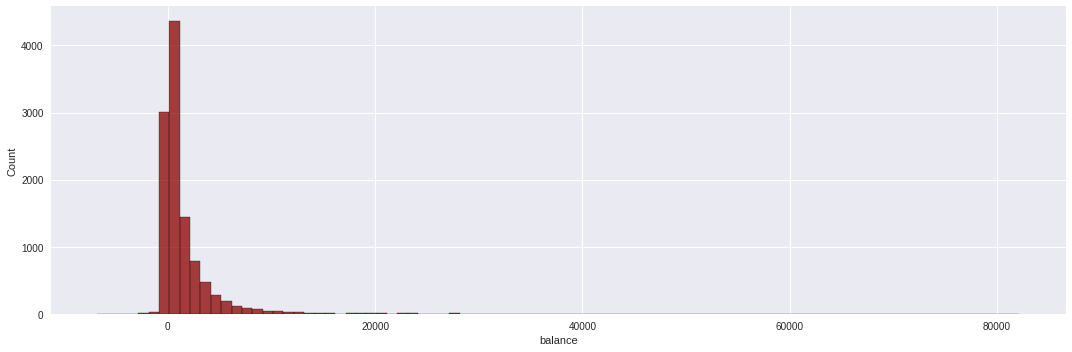

In [11]:
sns.displot(data['balance'], binwidth=1000.0, color='darkred', aspect=3)

In [12]:
data['balance'].describe()

count    11137.000000
mean      1529.129029
std       3228.114892
min      -6847.000000
25%        123.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

In [13]:
LOG.info(f"Column 'balance' median value: {data['balance'].quantile(0.5)}")

2022-07-21 09:38:27,600 - Project-04-Classification - INFO - Column 'balance' median value: 550.0


### Задание 4

In [14]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median_balance = data['balance'].quantile(0.5)
data['balance'].fillna(median_balance, inplace=True)

In [15]:
LOG.info(f"Column 'balance' mean value: {data['balance'].mean():.3f}")

2022-07-21 09:38:27,693 - Project-04-Classification - INFO - Column 'balance' mean value: 1526.936


### Задание 5

In [16]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
def get_column_mode(data_column: pd.Series):
    modes = data_column.mode()
    assert len(modes) == 1, f"A few modes in the column '{data_column.name}': {modes}"
    return modes[0]


mode_job = get_column_mode(data['job'])
LOG.info(f"Column 'job' mode: {mode_job}")
data['job'] = data['job'].apply(lambda job: mode_job if job == 'unknown' else job)

mode_education = get_column_mode(data['education'])
LOG.info(f"Column 'education' mode: {mode_education}")
data['education'] = data['education'].apply(lambda education: mode_education if education == 'unknown' else education)

LOG.info('Missing data are replaced with mode values.')

2022-07-21 09:38:27,738 - Project-04-Classification - INFO - Column 'job' mode: management
2022-07-21 09:38:27,743 - Project-04-Classification - INFO - Column 'education' mode: secondary
2022-07-21 09:38:27,747 - Project-04-Classification - INFO - Missing data are replaced with mode values.


In [17]:
mode_job = get_column_mode(data['job'])
mode_education = get_column_mode(data['education'])

LOG.info(f"Mean 'balance' for most frequent job AND education: {data[(data['job'] == mode_job)&(data['education'] == mode_education)]['balance'].mean():.3f}")

2022-07-21 09:38:27,793 - Project-04-Classification - INFO - Mean 'balance' for most frequent job AND education: 1598.883


### Задание 6

In [18]:
# удалите все выбросы для признака balance
def calculate_outliers_tukeys_fences_method(data_column: pd.Series, return_information: bool = True):
    q1 = data_column.quantile(0.25)
    q3 = data_column.quantile(0.75)
    iqr = q3 - q1
    inner_fence = 1.5 * iqr
    outer_fence = 3 * iqr
    
    #Lower and upper Inner fences
    inner_fence_lower = q1 - inner_fence
    inner_fence_upper = q3 + inner_fence
    possible_outliers = data_column[(data_column < inner_fence_lower)|(data_column > inner_fence_upper)]
    LOG.info(f"Test: {possible_outliers.shape}")
    
    #Lower and upper outer fences
    outer_fence_lower = q1 - outer_fence
    outer_fence_upper = q3 + outer_fence
    probable_outliers = data_column[(data_column < outer_fence_lower)|(data_column > outer_fence_upper)]

    outlier_data = {
        'IQR': iqr,
        'possible': {
            'fences': {
                'lower': inner_fence_lower,
                'upper': inner_fence_upper
            },
            'indexes': possible_outliers.index,
            'values': possible_outliers
        },
        'probable': {
            'fences': {
                'lower': outer_fence_lower,
                'upper': outer_fence_upper
            },
            'indexes': probable_outliers.index,
            'values': probable_outliers
        }
    }

    if return_information:
        outlier_information = copy.deepcopy(outlier_data)
        del outlier_information['possible']['indexes']
        del outlier_information['possible']['values']
        del outlier_information['probable']['indexes']
        del outlier_information['probable']['values']
        outlier_information['possible']['left-count'] = len(possible_outliers[possible_outliers <= inner_fence_lower])
        outlier_information['possible']['right-count'] = len(possible_outliers[possible_outliers >= inner_fence_upper])
        outlier_information['probable']['left-count'] = len(probable_outliers[probable_outliers <= outer_fence_lower])
        outlier_information['probable']['right-count'] = len(probable_outliers[probable_outliers >= outer_fence_upper])
        return outlier_data, outlier_information
    else:
        return outlier_data
    


balance_outlier_data, balance_outlier_informaton = calculate_outliers_tukeys_fences_method(data['balance'], return_information=True)
LOG.info(f"Column 'balance' outlier information:\n{pprn.pformat(balance_outlier_informaton)}")

2022-07-21 09:38:27,838 - Project-04-Classification - INFO - Test: (1057,)
2022-07-21 09:38:27,840 - Project-04-Classification - INFO - Column 'balance' outlier information:
{'IQR': 1576.0,
 'possible': {'fences': {'lower': -2241.0, 'upper': 4063.0},
              'left-count': 4,
              'right-count': 1053},
 'probable': {'fences': {'lower': -4605.0, 'upper': 6427.0},
              'left-count': 1,
              'right-count': 514}}


In [19]:
LOG.info(f"Dropping dataset rows by possible outliers in the column 'balance'. Data length before the procedure - {len(data)}...")
balance_possible_outlier_data = balance_outlier_data['possible']
dataset = data.drop(data.index[balance_possible_outlier_data['indexes']]).reset_index()
LOG.info(f"... Done. Data length after the procedure - {len(dataset)}")

2022-07-21 09:38:27,886 - Project-04-Classification - INFO - Dropping dataset rows by possible outliers in the column 'balance'. Data length before the procedure - 11162...
2022-07-21 09:38:27,888 - Project-04-Classification - INFO - ... Done. Data length after the procedure - 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [20]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
dataset['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задание 2

In [21]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
LOG.info(f"Bank client maximum age: {dataset['age'].max()}")
LOG.info(f"Conversation minimum duration: {dataset['duration'].min()}")
LOG.info(f"Months of the campaign: {len(dataset['month'].unique())}")
LOG.info(f"Count of client jobs: {len(dataset['job'].unique())}")

2022-07-21 09:38:27,985 - Project-04-Classification - INFO - Bank client maximum age: 95
2022-07-21 09:38:27,986 - Project-04-Classification - INFO - Conversation minimum duration: 2
2022-07-21 09:38:27,987 - Project-04-Classification - INFO - Months of the campaign: 12
2022-07-21 09:38:27,987 - Project-04-Classification - INFO - Count of client jobs: 11


### Задание 3

In [22]:
# рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат


### Задание 4

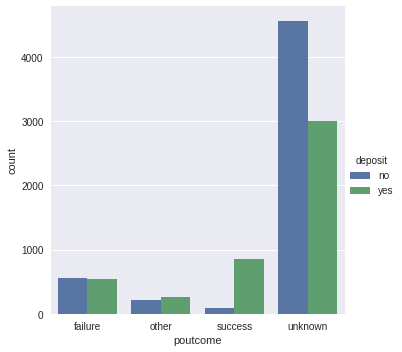

In [23]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
poutcome_deposit = dataset.groupby('poutcome', as_index=False)[
    'deposit'].value_counts()

import plotly.express as px
fig = px.bar(poutcome_deposit, x="poutcome", y="count", color="deposit", title="poutcome - deposit")
fig.show()

sns.catplot(x='poutcome', y='count', hue='deposit',
            data=poutcome_deposit, kind='bar')

### Задание 5

In [24]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# res_n = dataset[dataset.deposit == 'no'].groupby(['month'])['deposit'].count()
month_deposit = dataset.groupby('month', as_index=True)['deposit'].value_counts().unstack('deposit')
refusal_rates_by_month = month_deposit['no'] / month_deposit['yes']
LOG.info(f"Maximum rate of new deposit refusals by months: Month - '{refusal_rates_by_month.idxmax()}', Rate - {refusal_rates_by_month.max():.3f}")

2022-07-21 09:38:28,518 - Project-04-Classification - INFO - Maximum rate of new deposit refusals by months: Month - 'may', Rate - 2.112


### Задание 6

2022-07-21 09:38:28,586 - Project-04-Classification - INFO - Sorted 'age_group' groups which open new deposits:
age_group
60+      3.159236
<30      1.449495
30-40    0.764365
50-60    0.680894
40-50    0.649584
Name: new_deposit_rate, dtype: float64


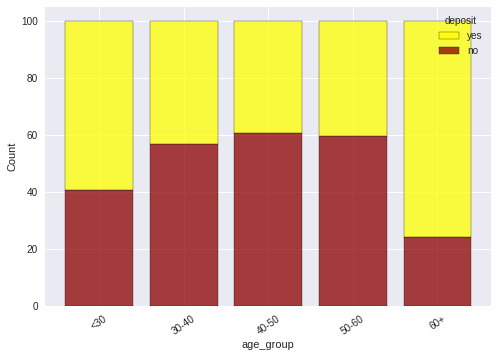

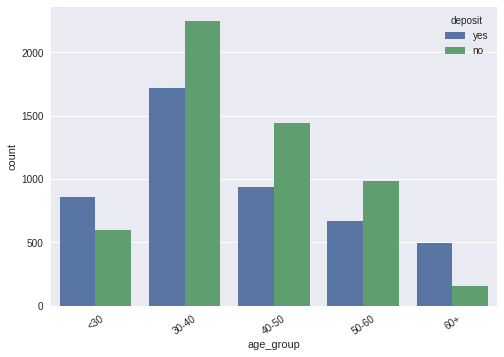

In [25]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# 30 value is in the group [30, 40).
dataset['age_group'] = pd.cut(
    dataset['age'],
    bins=[0, 30, 40, 50, 60, 200], labels=['<30', '30-40', '40-50', '50-60', '60+'],
    right=False, include_lowest=True
)


def find_new_deposit_rates(dataset: pd.DataFrame, group_column: str, plot_groups: bool = True):
    deposit_rates_by_group_column = dataset.groupby(group_column, as_index=True)['deposit'].value_counts(normalize=True).unstack('deposit')
    deposit_rates_by_group_column['new_deposit_rate'] = deposit_rates_by_group_column['yes'] / deposit_rates_by_group_column['no']
    top_new_deposit_group_column = deposit_rates_by_group_column['new_deposit_rate'].sort_values(ascending=False)
    LOG.info(f"Sorted 'age_group' groups which open new deposits:\n{top_new_deposit_group_column}")

    if plot_groups:
        deposits_by_group_column = dataset.groupby([group_column])['deposit'].value_counts(normalize=True).mul(100).reset_index(name='percentage')
        ax = sns.histplot(x=group_column, hue='deposit', weights='percentage', multiple='stack', palette={'no': 'darkred', 'yes': 'yellow'}, data=deposits_by_group_column, shrink=0.8)
        ax.tick_params(axis='x', rotation=35)
        plt.show()

        ax = sns.countplot(x=group_column, hue='deposit', data=dataset)
        ax.tick_params(axis='x', rotation=35)
        plt.show()

    return top_new_deposit_group_column


age_group_rates = find_new_deposit_rates(dataset, 'age_group')

### Задание 7

2022-07-21 09:38:29,080 - Project-04-Classification - INFO - Sorted 'age_group' groups which open new deposits:
marital
single      1.146293
divorced    0.886218
married     0.730245
Name: new_deposit_rate, dtype: float64


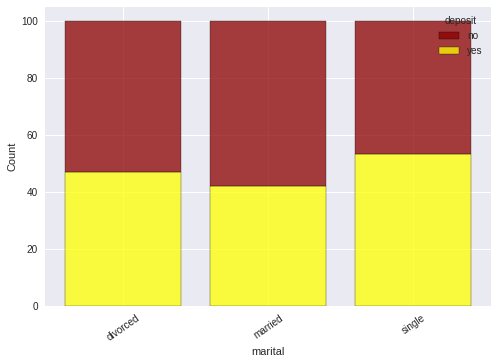

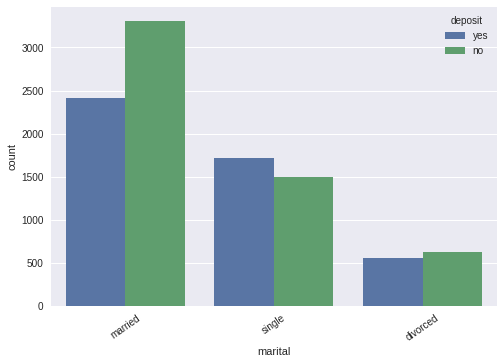

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

marital_rates = find_new_deposit_rates(dataset, 'marital')

2022-07-21 09:38:29,305 - Project-04-Classification - INFO - Sorted 'age_group' groups which open new deposits:
education
tertiary     1.122543
secondary    0.799413
primary      0.621394
Name: new_deposit_rate, dtype: float64


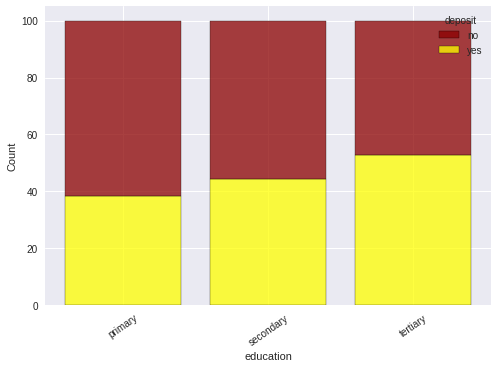

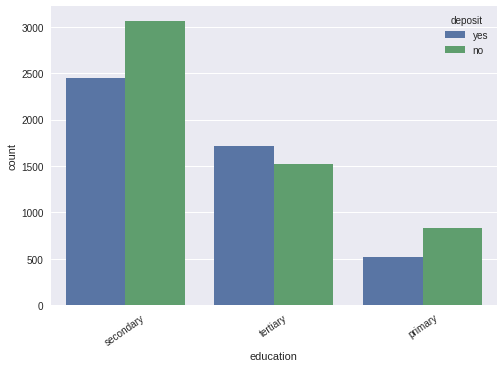

In [27]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

education_rates = find_new_deposit_rates(dataset, 'education')

2022-07-21 09:38:29,521 - Project-04-Classification - INFO - Sorted 'age_group' groups which open new deposits:
job
student          3.024691
retired          1.870130
unemployed       1.321678
management       0.961864
admin.           0.854167
technician       0.820000
self-employed    0.817259
services         0.659656
housemaid        0.647059
entrepreneur     0.587302
blue-collar      0.564502
Name: new_deposit_rate, dtype: float64


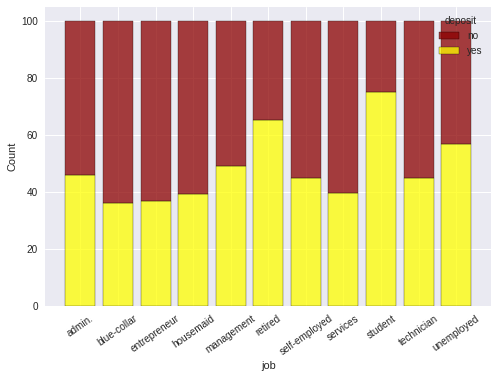

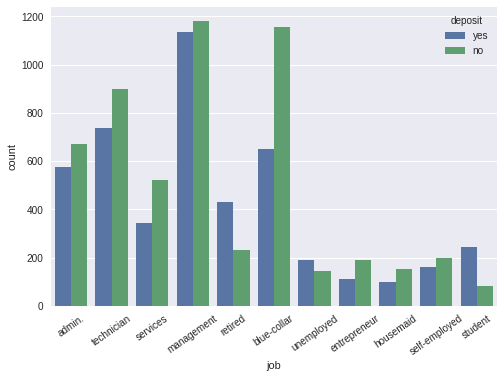

In [28]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

job_rates = find_new_deposit_rates(dataset, 'job')

### Задание 8

2022-07-21 09:38:29,828 - Project-04-Classification - INFO - Education/Marital Status [deposit = 'yes']:
education  primary  secondary  tertiary
marital                                
divorced        96        283       174
married        339       1289       784
single          82        879       755


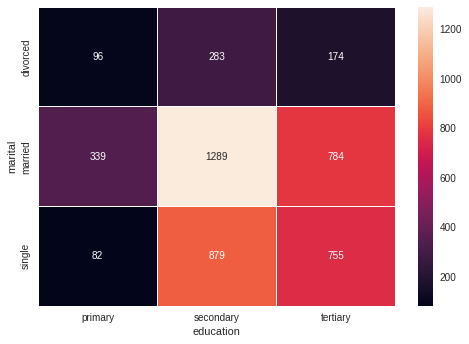

2022-07-21 09:38:29,923 - Project-04-Classification - INFO - ----------
2022-07-21 09:38:29,932 - Project-04-Classification - INFO - Education/Marital Status [deposit = 'no']:
education  primary  secondary  tertiary
marital                                
divorced        91        370       163
married        641       1830       832
single         100        866       531


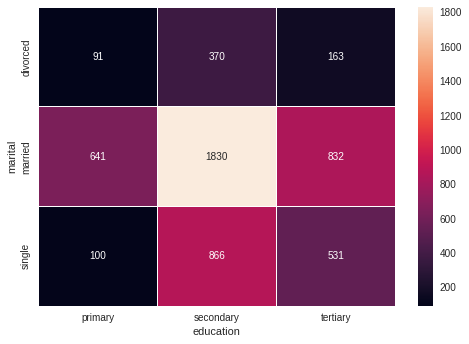

In [29]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

dataset_deposit = dataset[dataset['deposit'] == 'yes']
education_marital_deposit = pd.pivot_table(dataset_deposit, index='marital', columns='education', values='index', aggfunc='count')
LOG.info(f"Education/Marital Status [deposit = 'yes']:\n{pprn.pformat(education_marital_deposit)}")
figure = sns.heatmap(education_marital_deposit, annot=True, fmt="d", linewidths=.5)
plt.show()

LOG.info('----------')

dataset_deposit = dataset[dataset['deposit'] == 'no']
education_marital_deposit = pd.pivot_table(dataset_deposit, index='marital', columns='education', values='index', aggfunc='count')
LOG.info(f"Education/Marital Status [deposit = 'no']:\n{pprn.pformat(education_marital_deposit)}")
figure = sns.heatmap(education_marital_deposit, annot=True, fmt="d", linewidths=.5)
plt.show()

## Часть 3: преобразование данных

In [30]:
dataset.head(7)

index  age         job  marital  education default  balance housing loan  \
0      0   59      admin.  married  secondary      no   2343.0     yes   no   
1      1   56      admin.  married  secondary      no     45.0      no   no   
2      2   41  technician  married  secondary      no   1270.0     yes   no   
3      3   55    services  married  secondary      no   2476.0     yes   no   
4      4   54      admin.  married   tertiary      no    184.0      no   no   
5      5   42  management   single   tertiary      no      0.0     yes  yes   
6      6   56  management  married   tertiary      no    830.0     yes  yes   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  \
0  unknown    5   may      1042         1     -1         0  unknown     yes   
1  unknown    5   may      1467         1     -1         0  unknown     yes   
2  unknown    5   may      1389         1     -1         0  unknown     yes   
3  unknown    5   may       579         1     -1         0  unknown     yes   
4  unknown    5   may       673         2     -1         0  unknown     yes   
5  unknown    5   may       562         2     -1         0  unknown     yes   
6  unknown    6   may      1201         1     -1         0  unknown     yes   

  age_group  
0     50-60  
1     50-60  
2     40-50  
3     50-60  
4     50-60  
5     40-50  
6     50-60

### Задание 1

In [31]:
# преобразуйте уровни образования
education_encoder = LabelEncoder()
dataset['education'] = education_encoder.fit_transform(dataset['education'])
LOG.info(f"Sum of the encoded education values: {dataset['education'].sum()}")

dataset.head(7)

2022-07-21 09:38:30,146 - Project-04-Classification - INFO - Sum of the encoded education values: 11995


index  age         job  marital  education default  balance housing loan  \
0      0   59      admin.  married          1      no   2343.0     yes   no   
1      1   56      admin.  married          1      no     45.0      no   no   
2      2   41  technician  married          1      no   1270.0     yes   no   
3      3   55    services  married          1      no   2476.0     yes   no   
4      4   54      admin.  married          2      no    184.0      no   no   
5      5   42  management   single          2      no      0.0     yes  yes   
6      6   56  management  married          2      no    830.0     yes  yes   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  \
0  unknown    5   may      1042         1     -1         0  unknown     yes   
1  unknown    5   may      1467         1     -1         0  unknown     yes   
2  unknown    5   may      1389         1     -1         0  unknown     yes   
3  unknown    5   may       579         1     -1         0  unknown     yes   
4  unknown    5   may       673         2     -1         0  unknown     yes   
5  unknown    5   may       562         2     -1         0  unknown     yes   
6  unknown    6   may      1201         1     -1         0  unknown     yes   

  age_group  
0     50-60  
1     50-60  
2     40-50  
3     50-60  
4     50-60  
5     40-50  
6     50-60

In [32]:
age_group_encoder = LabelEncoder()
dataset['age_group'] = education_encoder.fit_transform(dataset['age_group'])
# LOG.info(f"Sum of the encoded age group values: {dataset['age_group'].sum()}")

dataset.head(7)

index  age         job  marital  education default  balance housing loan  \
0      0   59      admin.  married          1      no   2343.0     yes   no   
1      1   56      admin.  married          1      no     45.0      no   no   
2      2   41  technician  married          1      no   1270.0     yes   no   
3      3   55    services  married          1      no   2476.0     yes   no   
4      4   54      admin.  married          2      no    184.0      no   no   
5      5   42  management   single          2      no      0.0     yes  yes   
6      6   56  management  married          2      no    830.0     yes  yes   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  \
0  unknown    5   may      1042         1     -1         0  unknown     yes   
1  unknown    5   may      1467         1     -1         0  unknown     yes   
2  unknown    5   may      1389         1     -1         0  unknown     yes   
3  unknown    5   may       579         1     -1         0  unknown     yes   
4  unknown    5   may       673         2     -1         0  unknown     yes   
5  unknown    5   may       562         2     -1         0  unknown     yes   
6  unknown    6   may      1201         1     -1         0  unknown     yes   

   age_group  
0          2  
1          2  
2          1  
3          2  
4          2  
5          1  
6          2

### Задание 2

In [33]:
# преобразуйте бинарные переменные в представление из нулей и единиц

deposit_encoder = preprocessing.LabelBinarizer()
dataset['deposit'] = deposit_encoder.fit_transform(dataset['deposit'])
LOG.info(f"Std. dev. of the encoded deposit values: {dataset['deposit'].std():.3f}")

# -----

default_encoder = preprocessing.LabelBinarizer()
dataset['default'] = default_encoder.fit_transform(dataset['default'])

housing_encoder = preprocessing.LabelBinarizer()
dataset['housing'] = housing_encoder.fit_transform(dataset['housing'])

loan_encoder = preprocessing.LabelBinarizer()
dataset['loan'] = loan_encoder.fit_transform(dataset['loan'])

LOG.info(f"Sum of binary variable mean values: {np.sum([dataset['default'].mean(), dataset['housing'].mean(), dataset['loan'].mean()]):.3f}")

LOG.info(f"Number of independent features: {dataset.shape[1] - 1}")

dataset.head(7)

2022-07-21 09:38:30,302 - Project-04-Classification - INFO - Std. dev. of the encoded deposit values: 0.499
2022-07-21 09:38:30,353 - Project-04-Classification - INFO - Sum of binary variable mean values: 0.635
2022-07-21 09:38:30,353 - Project-04-Classification - INFO - Number of independent features: 18


index  age         job  marital  education  default  balance  housing  \
0      0   59      admin.  married          1        0   2343.0        1   
1      1   56      admin.  married          1        0     45.0        0   
2      2   41  technician  married          1        0   1270.0        1   
3      3   55    services  married          1        0   2476.0        1   
4      4   54      admin.  married          2        0    184.0        0   
5      5   42  management   single          2        0      0.0        1   
6      6   56  management  married          2        0    830.0        1   

   loan  contact  day month  duration  campaign  pdays  previous poutcome  \
0     0  unknown    5   may      1042         1     -1         0  unknown   
1     0  unknown    5   may      1467         1     -1         0  unknown   
2     0  unknown    5   may      1389         1     -1         0  unknown   
3     0  unknown    5   may       579         1     -1         0  unknown   
4     0  unknown    5   may       673         2     -1         0  unknown   
5     1  unknown    5   may       562         2     -1         0  unknown   
6     1  unknown    6   may      1201         1     -1         0  unknown   

   deposit  age_group  
0        1          2  
1        1          2  
2        1          1  
3        1          2  
4        1          2  
5        1          1  
6        1          2

### Задание 3

In [34]:
# создайте дамми-переменные
dataset_dummies = pd.get_dummies(dataset[['job', 'marital', 'contact', 'month', 'poutcome']])
dataset = dataset.join(dataset_dummies)
dataset.drop(['index'], axis=1, inplace=True)
LOG.info(f"Number of independent features: {dataset.shape[1] - 1}")
dataset.head(7)

2022-07-21 09:38:30,512 - Project-04-Classification - INFO - Number of independent features: 50


age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married          1        0   2343.0        1     0   
1   56      admin.  married          1        0     45.0        0     0   
2   41  technician  married          1        0   1270.0        1     0   
3   55    services  married          1        0   2476.0        1     0   
4   54      admin.  married          2        0    184.0        0     0   
5   42  management   single          2        0      0.0        1     1   
6   56  management  married          2        0    830.0        1     1   

   contact  day  ... month_jun  month_mar  month_may  month_nov  month_oct  \
0  unknown    5  ...         0          0          1          0          0   
1  unknown    5  ...         0          0          1          0          0   
2  unknown    5  ...         0          0          1          0          0   
3  unknown    5  ...         0          0          1          0          0   
4  unknown    5  ...         0          0          1          0          0   
5  unknown    5  ...         0          0          1          0          0   
6  unknown    6  ...         0          0          1          0          0   

  month_sep  poutcome_failure  poutcome_other  poutcome_success  \
0         0                 0               0                 0   
1         0                 0               0                 0   
2         0                 0               0                 0   
3         0                 0               0                 0   
4         0                 0               0                 0   
5         0                 0               0                 0   
6         0                 0               0                 0   

   poutcome_unknown  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
5                 1  
6                 1  

[7 rows x 51 columns]

In [65]:
dataset.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit', 'age_group', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задание 4

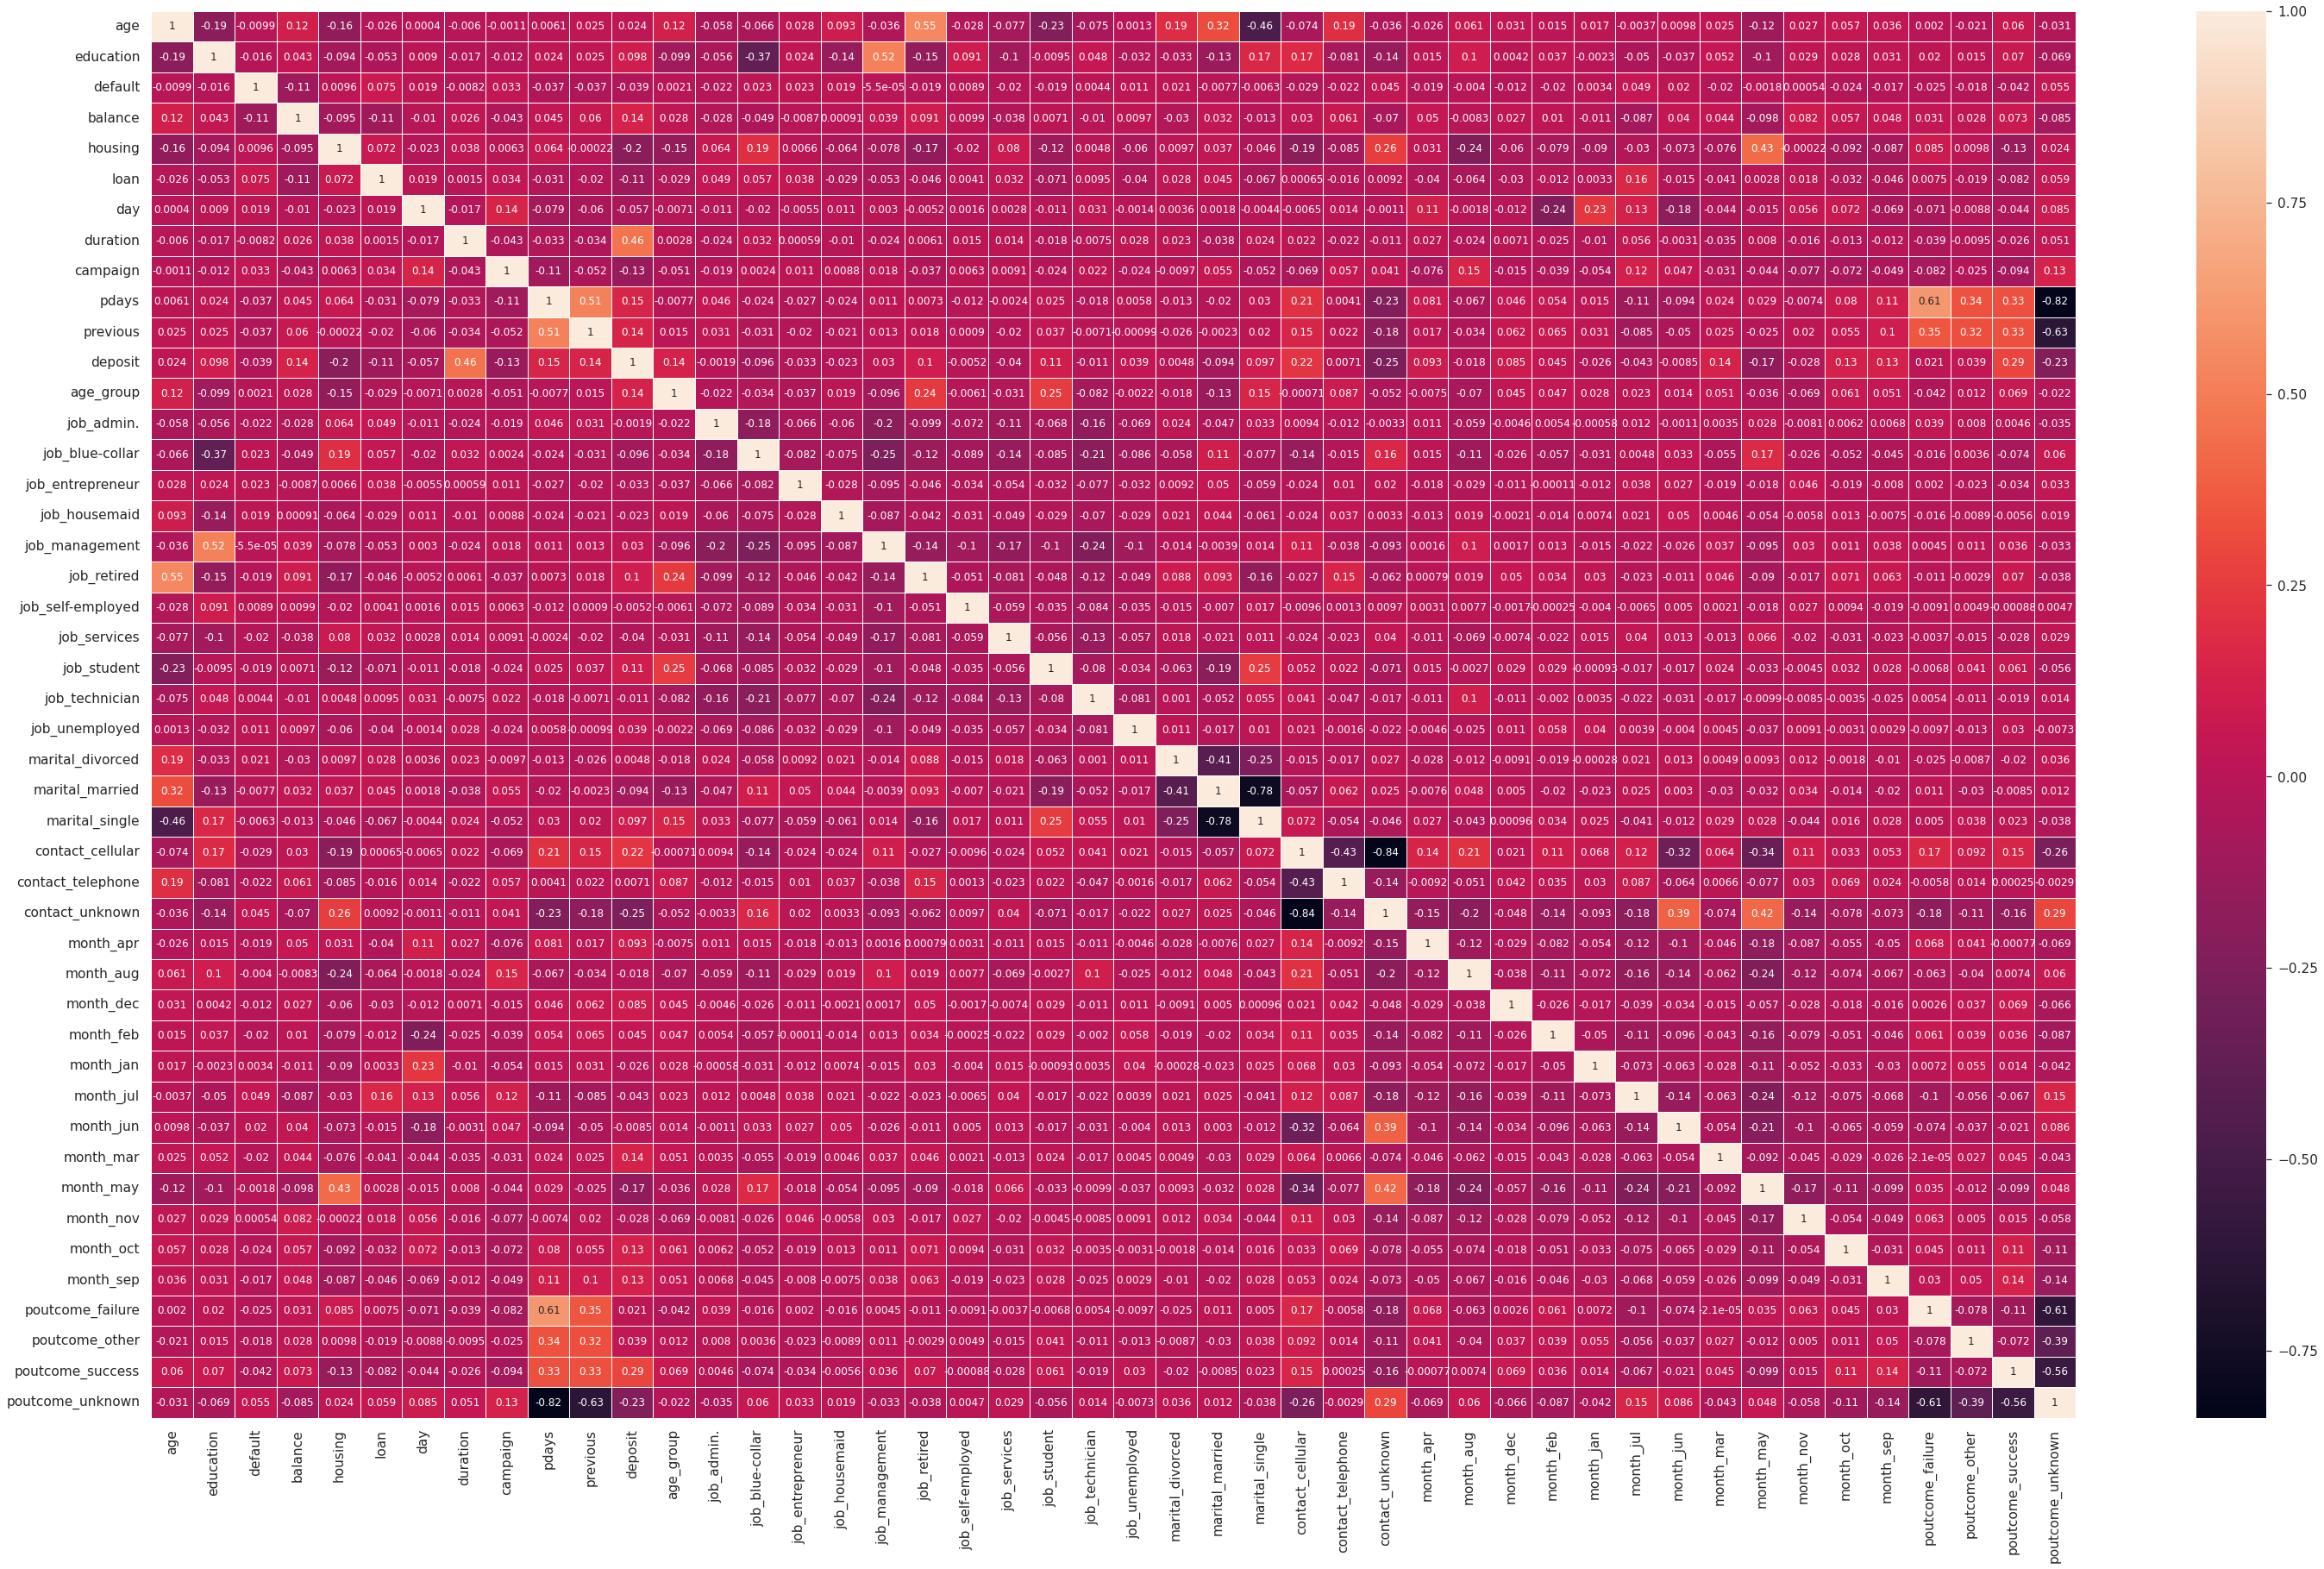

In [64]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(50,30))
sns.heatmap(dataset.corr(), annot=True, linewidths=.5, ax=ax, annot_kws={"size": 12})
plt.show()

In [70]:
dataset_corr_linear = dataset.corr()
dataset_corr_linear['deposit'].abs().sort_values(ascending=False).head(10)

deposit             1.000000
duration            0.457818
poutcome_success    0.288491
contact_unknown     0.249294
poutcome_unknown    0.228300
contact_cellular    0.223944
housing             0.200290
month_may           0.168203
pdays               0.147917
previous            0.141102
Name: deposit, dtype: float64

### Задание 5

In [93]:
linear_correlations_abs_values = dataset_corr_linear.abs().unstack().sort_values(ascending=False)
linear_correlations_abs_values[linear_correlations_abs_values.index.get_level_values(0) != linear_correlations_abs_values.index.get_level_values(1)]

contact_unknown   contact_cellular    0.837885
contact_cellular  contact_unknown     0.837885
poutcome_unknown  pdays               0.824031
pdays             poutcome_unknown    0.824031
marital_married   marital_single      0.779038
                                        ...   
job_entrepreneur  month_feb           0.000112
default           job_management      0.000055
job_management    default             0.000055
month_mar         poutcome_failure    0.000021
poutcome_failure  month_mar           0.000021
Length: 2070, dtype: float64

In [98]:
dataset.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit', 'age_group', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [100]:
dataset_ready = dataset.drop(['job', 'marital', 'contact', 'month', 'poutcome'], axis=1)

In [101]:
X = dataset_ready.drop(['deposit'], axis=1)
y = dataset_ready['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)

LOG.info(f"Train sample shape: {X_train.shape}")
LOG.info(f"Test sample shape: {X_test.shape}")

2022-07-21 10:19:31,436 - Project-04-Classification - INFO - Train sample shape: (6770, 45)
2022-07-21 10:19:31,436 - Project-04-Classification - INFO - Test sample shape: (3335, 45)


In [102]:
# рассчитайте необходимые показатели

LOG.info(f"Deposit mean value on the test sample: {np.mean(y_test):.2f}")

2022-07-21 10:19:37,004 - Project-04-Classification - INFO - Deposit mean value on the test sample: 0.46


### Задание 6

In [103]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков


k_best_selector = SelectKBest(score_func=f_classif, k=15)
X_train_new = k_best_selector.fit_transform(X_train, y_train)
X_test_new = k_best_selector.transform(X_test)

LOG.info(f"Train sample shape: {X_train_new.shape}")
LOG.info(f"Test sample shape: {X_test_new.shape}")

2022-07-21 10:19:44,153 - Project-04-Classification - INFO - Train sample shape: (6770, 15)
2022-07-21 10:19:44,154 - Project-04-Classification - INFO - Test sample shape: (3335, 15)


In [111]:
selected_features = k_best_selector.get_feature_names_out()
LOG.info(f"Selected features:\n{pprn.pformat(selected_features)}")

2022-07-21 10:44:13,192 - Project-04-Classification - INFO - Selected features:
array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)


### Задание 7

In [116]:
# нормализуйте данные с помощью minmaxsxaler
dataset_featured = dataset_ready[[*selected_features, 'deposit']]

X = dataset_featured.drop(['deposit'], axis=1)
y = dataset_featured['deposit']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)
LOG.info(f"Train sample shape: {X_train.shape}")
LOG.info(f"Test sample shape: {X_test.shape}")

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

LOG.info(f"Test sample shape: {X_test_scaled[:, 0].mean():.2f}")

2022-07-21 10:50:29,250 - Project-04-Classification - INFO - Train sample shape: (6770, 15)
2022-07-21 10:50:29,250 - Project-04-Classification - INFO - Test sample shape: (3335, 15)
2022-07-21 10:50:29,254 - Project-04-Classification - INFO - Test sample shape: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [125]:
def log_scores(X_train, Y_train, X_test, Y_test, optimization_algorithm_instance):
    Y_predicted_train = optimization_algorithm_instance.predict(X_train)
    LOG.info(f"{colored('F1-score', 'red')}, train dataset: {metrics.f1_score(Y_train, Y_predicted_train)}")
    LOG.info(f"{colored('Precision', 'magenta')}, train dataset: {metrics.precision_score(Y_train, Y_predicted_train)}")
    LOG.info(f"{colored('Recall', 'blue')}, train dataset: {metrics.recall_score(Y_train, Y_predicted_train)}")
    LOG.info(f"{colored('Accuracy', 'green')}, train dataset: {metrics.accuracy_score(Y_train, Y_predicted_train)}")
    LOG.info("-----")
    Y_predicted_test = optimization_algorithm_instance.predict(X_test)
    LOG.info(f"{colored('F1-score', 'red')}, test dataset: {metrics.f1_score(Y_test, Y_predicted_test)}")
    LOG.info(f"{colored('Precision', 'magenta')}, test dataset: {metrics.precision_score(Y_test, Y_predicted_test)}")
    LOG.info(f"{colored('Recall', 'blue')}, test dataset: {metrics.recall_score(Y_test, Y_predicted_test)}")
    LOG.info(f"{colored('Accuracy', 'green')}, test dataset: {metrics.accuracy_score(Y_test, Y_predicted_test)}")
    LOG.info("-----")
    LOG.info(f"Classification Report for the test sample:\n{metrics.classification_report(Y_test, Y_predicted_test)}")

### Задание 1

In [126]:
# обучите логистическую регрессию и рассчитайте метрики качества
basic_model_lregression = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
basic_model_lregression.fit(X_train_scaled, y_train)
log_scores(X_train_scaled, y_train, X_test_scaled, y_test, basic_model_lregression)

2022-07-21 11:06:23,709 - Project-04-Classification - INFO - F1-score, train dataset: 0.8008708759001841
2022-07-21 11:06:23,712 - Project-04-Classification - INFO - Precision, train dataset: 0.8433862433862434
2022-07-21 11:06:23,714 - Project-04-Classification - INFO - Recall, train dataset: 0.7624362244897959
2022-07-21 11:06:23,714 - Project-04-Classification - INFO - Accuracy, train dataset: 0.8243722304283604
2022-07-21 11:06:23,715 - Project-04-Classification - INFO - -----
2022-07-21 11:06:23,716 - Project-04-Classification - INFO - F1-score, test dataset: 0.7769784172661871
2022-07-21 11:06:23,718 - Project-04-Classification - INFO - Precision, test dataset: 0.8253275109170306
2022-07-21 11:06:23,719 - Project-04-Classification - INFO - Recall, test dataset: 0.7339805825242719
2022-07-21 11:06:23,720 - Project-04-Classification - INFO - Accuracy, test dataset: 0.8047976011994002
2022-07-21 11:06:23,721 - Project-04-Classification - INFO - -----
2022-07-21 11:06:23,725 - Projec

### Задание 2

In [127]:
# обучите решающие деревья, настройте максимальную глубину
basic_model_decisiontree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
basic_model_decisiontree.fit(X_train_scaled, y_train)   
log_scores(X_train_scaled, y_train, X_test_scaled, y_test, basic_model_decisiontree)

2022-07-21 11:08:56,177 - Project-04-Classification - INFO - F1-score, train dataset: 1.0
2022-07-21 11:08:56,180 - Project-04-Classification - INFO - Precision, train dataset: 1.0
2022-07-21 11:08:56,182 - Project-04-Classification - INFO - Recall, train dataset: 1.0
2022-07-21 11:08:56,183 - Project-04-Classification - INFO - Accuracy, train dataset: 1.0
2022-07-21 11:08:56,184 - Project-04-Classification - INFO - -----
2022-07-21 11:08:56,186 - Project-04-Classification - INFO - F1-score, test dataset: 0.7220573689416419
2022-07-21 11:08:56,187 - Project-04-Classification - INFO - Precision, test dataset: 0.7358870967741935
2022-07-21 11:08:56,189 - Project-04-Classification - INFO - Recall, test dataset: 0.7087378640776699
2022-07-21 11:08:56,190 - Project-04-Classification - INFO - Accuracy, test dataset: 0.7472263868065967
2022-07-21 11:08:56,190 - Project-04-Classification - INFO - -----
2022-07-21 11:08:56,194 - Project-04-Classification - INFO - Classification Report for the t

In [135]:
basic_model_decisiontree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2, random_state=42)
basic_model_decisiontree.fit(X_train_scaled, y_train)   
log_scores(X_train_scaled, y_train, X_test_scaled, y_test, basic_model_decisiontree)

2022-07-21 11:14:12,188 - Project-04-Classification - INFO - F1-score, train dataset: 0.813013073882639
2022-07-21 11:14:12,190 - Project-04-Classification - INFO - Precision, train dataset: 0.7768739105171412
2022-07-21 11:14:12,193 - Project-04-Classification - INFO - Recall, train dataset: 0.8526785714285714
2022-07-21 11:14:12,193 - Project-04-Classification - INFO - Accuracy, train dataset: 0.8183161004431314
2022-07-21 11:14:12,194 - Project-04-Classification - INFO - -----
2022-07-21 11:14:12,196 - Project-04-Classification - INFO - F1-score, test dataset: 0.8032128514056225
2022-07-21 11:14:12,197 - Project-04-Classification - INFO - Precision, test dataset: 0.7683215130023641
2022-07-21 11:14:12,200 - Project-04-Classification - INFO - Recall, test dataset: 0.8414239482200647
2022-07-21 11:14:12,201 - Project-04-Classification - INFO - Accuracy, test dataset: 0.8089955022488755
2022-07-21 11:14:12,201 - Project-04-Classification - INFO - -----
2022-07-21 11:14:12,207 - Project

### Задание 3

In [151]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV


hyper_parameters = {
    # 'criterion': ['entropy'],
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}


scoring_type = 'accuracy'
optimization_algorithm_instance = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(),
    param_grid=hyper_parameters,
    scoring=scoring_type,
    cv=3,
    return_train_score=True,
    n_jobs=12,
    # verbose=3
)

optimization_algorithm_instance.fit(X_train_scaled, y_train)
score_value = optimization_algorithm_instance.score(X_test_scaled, y_test)
LOG.info(f"Best '{scoring_type}' value - {score_value:.2f}")
LOG.info(f"Best hyper-parameters found:\n{optimization_algorithm_instance.best_params_}")
log_scores(X_train_scaled, y_train, X_test_scaled, y_test, optimization_algorithm_instance)


2022-07-21 11:36:03,130 - Project-04-Classification - INFO - Best 'accuracy' value - 0.81
2022-07-21 11:36:03,131 - Project-04-Classification - INFO - Best hyper-parameters found:
{'max_depth': 7, 'min_samples_split': 10}
2022-07-21 11:36:03,134 - Project-04-Classification - INFO - F1-score, train dataset: 0.822572931611669
2022-07-21 11:36:03,137 - Project-04-Classification - INFO - Precision, train dataset: 0.8224418233981511
2022-07-21 11:36:03,140 - Project-04-Classification - INFO - Recall, train dataset: 0.8227040816326531
2022-07-21 11:36:03,141 - Project-04-Classification - INFO - Accuracy, train dataset: 0.8355982274741507
2022-07-21 11:36:03,141 - Project-04-Classification - INFO - -----
2022-07-21 11:36:03,144 - Project-04-Classification - INFO - F1-score, test dataset: 0.8017931476144734
2022-07-21 11:36:03,145 - Project-04-Classification - INFO - Precision, test dataset: 0.7934093789607097
2022-07-21 11:36:03,146 - Project-04-Classification - INFO - Recall, test dataset: 0

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [153]:
# обучите на ваших данных случайный лес

random_forest_basic_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
random_forest_basic_model.fit(X_train_scaled, y_train)

log_scores(X_train_scaled, y_train, X_test_scaled,
           y_test, random_forest_basic_model)


2022-07-21 11:39:50,649 - Project-04-Classification - INFO - F1-score, train dataset: 0.8483703353802551
2022-07-21 11:39:50,651 - Project-04-Classification - INFO - Precision, train dataset: 0.8379471228615863
2022-07-21 11:39:50,653 - Project-04-Classification - INFO - Recall, train dataset: 0.8590561224489796
2022-07-21 11:39:50,654 - Project-04-Classification - INFO - Accuracy, train dataset: 0.857754800590842
2022-07-21 11:39:50,655 - Project-04-Classification - INFO - -----
2022-07-21 11:39:50,683 - Project-04-Classification - INFO - F1-score, test dataset: 0.8185279187817259
2022-07-21 11:39:50,685 - Project-04-Classification - INFO - Precision, test dataset: 0.8027380211574362
2022-07-21 11:39:50,686 - Project-04-Classification - INFO - Recall, test dataset: 0.8349514563106796
2022-07-21 11:39:50,687 - Project-04-Classification - INFO - Accuracy, test dataset: 0.8284857571214392
2022-07-21 11:39:50,687 - Project-04-Classification - INFO - -----
2022-07-21 11:39:50,691 - Project

### Задание 2

In [171]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gradient_boosting_basic_model = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gradient_boosting_basic_model.fit(X_train_scaled, y_train)

log_scores(X_train_scaled, y_train, X_test_scaled,
           y_test, gradient_boosting_basic_model)
# LOG.info(f"GB feature importances:\n{pprn.pformat(gradient_boosting_basic_model.feature_importances_)}")
gb_feature_importances = list(zip(X.columns, gradient_boosting_basic_model.feature_importances_))
gb_feature_importances = sorted(gb_feature_importances, key=lambda it: it[1], reverse=True)
LOG.info(f"Features importances:\n{pprn.pformat(gb_feature_importances)}")

2022-07-22 08:34:34,480 - Project-04-Classification - INFO - F1-score, train dataset: 0.88
2022-07-22 08:34:34,482 - Project-04-Classification - INFO - Precision, train dataset: 0.8726873628096582
2022-07-22 08:34:34,484 - Project-04-Classification - INFO - Recall, train dataset: 0.8874362244897959
2022-07-22 08:34:34,484 - Project-04-Classification - INFO - Accuracy, train dataset: 0.8878877400295421
2022-07-22 08:34:34,485 - Project-04-Classification - INFO - -----
2022-07-22 08:34:34,500 - Project-04-Classification - INFO - F1-score, test dataset: 0.8167672276913305
2022-07-22 08:34:34,502 - Project-04-Classification - INFO - Precision, test dataset: 0.8017456359102244
2022-07-22 08:34:34,504 - Project-04-Classification - INFO - Recall, test dataset: 0.8323624595469256
2022-07-22 08:34:34,504 - Project-04-Classification - INFO - Accuracy, test dataset: 0.8269865067466267
2022-07-22 08:34:34,505 - Project-04-Classification - INFO - -----
2022-07-22 08:34:34,509 - Project-04-Classific

### Задание3

In [158]:
# объедините уже известные вам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier


ML_SEED = 42

estimators = [
    ('dtree', tree.DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10, random_state=ML_SEED)),
    ('lregression', linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=ML_SEED)),
    ('gradboosting', ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=ML_SEED))
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=ML_SEED))
stacking_model.fit(X_train_scaled, y_train)
log_scores(X_train_scaled, y_train, X_test_scaled, y_test, stacking_model)

2022-07-21 22:44:11,593 - Project-04-Classification - INFO - F1-score, train dataset: 0.858784107228339
2022-07-21 22:44:11,595 - Project-04-Classification - INFO - Precision, train dataset: 0.8594698179495369
2022-07-21 22:44:11,597 - Project-04-Classification - INFO - Recall, train dataset: 0.8580994897959183
2022-07-21 22:44:11,597 - Project-04-Classification - INFO - Accuracy, train dataset: 0.8692762186115214
2022-07-21 22:44:11,598 - Project-04-Classification - INFO - -----
2022-07-21 22:44:11,614 - Project-04-Classification - INFO - F1-score, test dataset: 0.8074814575943244
2022-07-21 22:44:11,615 - Project-04-Classification - INFO - Precision, test dataset: 0.8046272493573264
2022-07-21 22:44:11,616 - Project-04-Classification - INFO - Recall, test dataset: 0.8103559870550162
2022-07-21 22:44:11,617 - Project-04-Classification - INFO - Accuracy, test dataset: 0.8209895052473763
2022-07-21 22:44:11,617 - Project-04-Classification - INFO - -----
2022-07-21 22:44:11,621 - Project

### Задание 4

In [172]:
# оцените, какие признаки демонстрируют наибольшую важность в модели градиентного бустинга
gb_feature_importances = list(zip(X.columns, gradient_boosting_basic_model.feature_importances_))
gb_feature_importances = sorted(gb_feature_importances, key=lambda it: it[1], reverse=True)
LOG.info(f"Features importances:\n{pprn.pformat(gb_feature_importances)}")

2022-07-22 08:35:59,799 - Project-04-Classification - INFO - Features importances:
[('duration', 0.5019868598741399),
 ('poutcome_success', 0.11626370100249667),
 ('contact_unknown', 0.07376167754018612),
 ('balance', 0.05976435495521516),
 ('pdays', 0.05564682208682309),
 ('housing', 0.04658336768248357),
 ('age_group', 0.042101753497544483),
 ('month_mar', 0.026144241513862604),
 ('month_oct', 0.018823711273960028),
 ('campaign', 0.01710072626691799),
 ('month_may', 0.014507747393188991),
 ('month_sep', 0.013427506066882514),
 ('previous', 0.00890089467652086),
 ('contact_cellular', 0.0046001369592528546),
 ('poutcome_unknown', 0.000386499210525134)]


### Задание 5

In [199]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
from sklearn.model_selection import cross_val_score
from sklearn import exceptions

ML_SEED = 42
ML_JOBS = 12

SCORING = 'ROC-AUC'


def objective(trial: optuna.Trial):
    n_estimators     = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth        = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    n_jobs           = trial.suggest_categorical('n_jobs', [ML_JOBS])

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_jobs=n_jobs,
        random_state=ML_SEED
    )

    with warnings.catch_warnings():
        warnings.filterwarnings("error")
        try:
            model.fit(X_train, y_train)
            y_train_predicted = model.predict(X_train)
            y_train_predicted_proba = model.predict_proba(X_train)
            # score = metrics.f1_score(y_train, y_train_predicted)
            score = metrics.roc_auc_score(y_train, y_train_predicted_proba[:, 1])
            # score = cross_val_score(
            #     model, X_train, y_train, cv=5, scoring=SCORING, n_jobs=ML_JOBS).mean()

            # LOG.info(f"TRIAL {trial.number}. Parameters: {trial.params}; Score: {score}")
            return score
        except Warning or exceptions.NotFittedError:
            LOG.error(f"NOT FITTED; Model: {model}.\n----------")
            raise optuna.TrialPruned()


optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(objective, n_trials=20)
LOG.info(f"Best score value ('{SCORING}'): {study.best_value}")
best_parameters = dict(study.best_params)
LOG.info(f"Best parameters: {best_parameters}")

best_model = ensemble.RandomForestClassifier(
    **best_parameters,
    random_state=ML_SEED
)
best_model.fit(X_train, y_train)
log_scores(X_train, y_train, X_test, y_test, best_model)
y_test_predicted_proba = best_model.predict_proba(X_test)
test_roc_auc_score = metrics.roc_auc_score(y_test, y_test_predicted_proba[:, 1])
LOG.info(f"Test ROC-AUC score: {test_roc_auc_score}")

[I 2022-07-22 09:14:53,361] A new study created in memory with name: RandomForestClassifier
[I 2022-07-22 09:14:53,634] Trial 0 finished with value: 0.950767376983815 and parameters: {'n_estimators': 143, 'max_depth': 11, 'min_samples_leaf': 3, 'n_jobs': 12}. Best is trial 0 with value: 0.950767376983815.
[I 2022-07-22 09:14:53,915] Trial 1 finished with value: 0.9415315546623161 and parameters: {'n_estimators': 151, 'max_depth': 13, 'min_samples_leaf': 7, 'n_jobs': 12}. Best is trial 0 with value: 0.950767376983815.
[I 2022-07-22 09:14:54,133] Trial 2 finished with value: 0.9602709634349061 and parameters: {'n_estimators': 112, 'max_depth': 17, 'min_samples_leaf': 4, 'n_jobs': 12}. Best is trial 2 with value: 0.9602709634349061.
[I 2022-07-22 09:14:54,394] Trial 3 finished with value: 0.9489390520930443 and parameters: {'n_estimators': 152, 'max_depth': 22, 'min_samples_leaf': 6, 'n_jobs': 12}. Best is trial 2 with value: 0.9602709634349061.
[I 2022-07-22 09:14:54,720] Trial 4 finishe

2022-07-22 09:14:58,308 - Project-04-Classification - INFO - Best score value ('ROC-AUC'): 0.987782093437265
2022-07-22 09:14:58,309 - Project-04-Classification - INFO - Best parameters: {'n_estimators': 130, 'max_depth': 26, 'min_samples_leaf': 2, 'n_jobs': 12}
2022-07-22 09:14:58,518 - Project-04-Classification - INFO - F1-score, train dataset: 0.924185463659148
2022-07-22 09:14:58,521 - Project-04-Classification - INFO - Precision, train dataset: 0.9082512315270936
2022-07-22 09:14:58,523 - Project-04-Classification - INFO - Recall, train dataset: 0.9406887755102041
2022-07-22 09:14:58,524 - Project-04-Classification - INFO - Accuracy, train dataset: 0.9285081240768095
2022-07-22 09:14:58,525 - Project-04-Classification - INFO - -----
2022-07-22 09:14:58,552 - Project-04-Classification - INFO - F1-score, test dataset: 0.8174677976751492
2022-07-22 09:14:58,554 - Project-04-Classification - INFO - Precision, test dataset: 0.7942612942612942
2022-07-22 09:14:58,556 - Project-04-Classi

In [200]:
optuna.visualization.plot_optimization_history(study, target_name="ROC-AUC score")

DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.

Figure({
    'data': [{'mode': 'markers',
              'name': 'ROC-AUC score',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19],
              'y': [0.950767376983815, 0.9415315546623161, 0.9602709634349061,
                    0.9489390520930443, 0.9566177797137015, 0.937825283181517,
                    0.9549716642986308, 0.9396857678473151, 0.9379644520851818,
                    0.9443708284428245, 0.9619413412723372, 0.9621406178046343,
                    0.9620510267260454, 0.987663282153808, 0.9876280073118956,
                    0.9877558566767378, 0.987782093437265, 0.9730322956094931,
                    0.9731936648489886, 0.9549379689272517]},
             {'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19],
              'y': array([0.95076738, 0.95076738, 0.96027096, 0.96027096, 0.96027096, 0.96027096,
                          0.96027096, 0.96027096, 0.96027096, 0.96027096, 0.96194134, 0.96214062,
                          0.96214062, 0.98766328, 0.98766328, 0.98775586, 0.98778209, 0.98778209,
                          0.98778209, 0.98778209])}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': '#Trials'}},
               'yaxis': {'title': {'text': 'ROC-AUC score'}}}
})